In [1]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import pandas as pd
from classes_synsets import SYNS

In [2]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()

image_embeddings_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/image_embeddings.pt").cpu()
labels_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/labels.pt").cpu()

image_embeddings_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/image_embeddings.pt").cpu()
labels_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/labels.pt").cpu()


In [3]:
inds = np.array(random.choices(range(50000), k=10000))

small_ie = image_embeddings[inds]
small_labels = labels[inds]
print(small_ie.shape, small_labels.shape)

torch.Size([10000, 1024]) torch.Size([10000])


In [4]:
# Load Model

clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

In [5]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [6]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
text_embs.shape

torch.Size([1000, 1024])

In [8]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}

In [9]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [10]:
many_labels = []
many_embs = []
many_inds = []
med_labels = []
med_embs = []
med_inds = []
few_labels = []
few_embs = []
few_inds = []

for i in tqdm(range(image_embeddings.shape[0])):
    if freqs[labels[i].item()] >= 100:
        many_labels.append(labels[i])
        many_embs.append(image_embeddings[i, :])
        many_inds.append(i)
    elif freqs[labels[i].item()] >= 20:
        med_labels.append(labels[i])
        med_embs.append(image_embeddings[i, :])
        med_inds.append(i)
    else:
        few_labels.append(labels[i])
        few_embs.append(image_embeddings[i, :])
        few_inds.append(i)
        
many_embs = torch.stack(many_embs)
med_embs = torch.stack(med_embs)
few_embs = torch.stack(few_embs)

many_inds = np.array(many_inds)
med_inds = np.array(med_inds)
few_inds = np.array(few_inds)


  0%|          | 0/50000 [00:00<?, ?it/s]

### Alternate Train(?) scheme: Only FT on Image and only FT on Text

In [11]:
def all_accs(model):
    preds = model.predict(image_embeddings)
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [12]:
def all_accs_p(preds):
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [13]:
text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_liblinear/06-Nov-2022-01-47-08/final_model.sav", 'rb'))

image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_oversampled_auto/class_balanced/07-Nov-2022-20-13-26/final_model.sav", 'rb'))

In [14]:
all_accs(image_only_clf_oversampled)

0.621/0.721/0.606/0.386


[0.62108, 0.7208184143222507, 0.6062579281183932, 0.38588235294117645]

In [15]:
all_accs(text_only_balanced_clf)

0.544/0.558/0.542/0.512


[0.54418, 0.5579539641943734, 0.542029598308668, 0.5120588235294118]

In [16]:
def class_wise_accuracy(preds, labels):
    accs = np.zeros(1000)
    corr = preds == labels
    for i in range(len(labels)):
        if corr[i] == True:
            accs[labels[i]] +=1
    accs /= (len(labels)/1000)
    return accs

### Varying number of iterations

In [17]:
image_lp_iters = []
import os
from pathlib import Path

for i in range(100):
    fn = f"results_sklearn/config_image_linear_probe_0/ub_max_iter_{i}"
    if os.path.isdir(fn):
        out = None
        for path in Path(fn).rglob('*final_model.sav'):
            out = path
        print(out)
        if out is not None:
            image_lp_iters.append(pickle.load(open(out, 'rb')))


results_sklearn/config_image_linear_probe_0/ub_max_iter_1/13-Nov-2022-22-53-30/final_model.sav
results_sklearn/config_image_linear_probe_0/ub_max_iter_2/21-Nov-2022-11-32-38/final_model.sav
results_sklearn/config_image_linear_probe_0/ub_max_iter_3/21-Nov-2022-11-32-39/final_model.sav
results_sklearn/config_image_linear_probe_0/ub_max_iter_4/21-Nov-2022-11-32-41/final_model.sav
results_sklearn/config_image_linear_probe_0/ub_max_iter_5/13-Nov-2022-22-37-28/final_model.sav
results_sklearn/config_image_linear_probe_0/ub_max_iter_6/21-Nov-2022-11-32-42/final_model.sav
results_sklearn/config_image_linear_probe_0/ub_max_iter_8/21-Nov-2022-11-33-45/final_model.sav
results_sklearn/config_image_linear_probe_0/ub_max_iter_9/21-Nov-2022-11-33-43/final_model.sav
results_sklearn/config_image_linear_probe_0/ub_max_iter_10/13-Nov-2022-22-38-30/final_model.sav
results_sklearn/config_image_linear_probe_0/ub_max_iter_11/21-Nov-2022-11-46-39/final_model.sav
results_sklearn/config_image_linear_probe_0/ub_m

In [18]:
pred_proba_list = [m.predict_proba(image_embeddings) for m in tqdm(image_lp_iters)]

  0%|          | 0/43 [00:00<?, ?it/s]

In [19]:
pred_proba_arr = np.array(pred_proba_list)
np.savez('pred_proba_arr.npz', arr1=pred_proba_arr)

In [23]:
pred_proba_list = [m.predict_proba(image_embeddings_val) for m in tqdm(image_lp_iters)]
pred_proba_arr = np.array(pred_proba_list)
np.savez('pred_proba_arr_val.npz', arr1=pred_proba_arr)

  0%|          | 0/43 [00:00<?, ?it/s]

In [24]:
pred_proba_arr

array([[[9.10051470e-04, 1.20206302e-03, 1.75337994e-03, ...,
         8.81789936e-04, 8.75349557e-04, 8.73831665e-04],
        [9.02310760e-04, 1.17644353e-03, 1.64665938e-03, ...,
         8.75666790e-04, 8.70329329e-04, 8.69412438e-04],
        [9.04109264e-04, 1.17545514e-03, 1.64534567e-03, ...,
         8.76806459e-04, 8.71847825e-04, 8.70906192e-04],
        ...,
        [9.08921449e-04, 1.15693432e-03, 1.57181543e-03, ...,
         8.82450075e-04, 8.79017087e-04, 8.79351446e-04],
        [9.07650858e-04, 1.15893875e-03, 1.57440307e-03, ...,
         8.83674985e-04, 8.80123981e-04, 8.80054630e-04],
        [9.06832758e-04, 1.16918470e-03, 1.57336970e-03, ...,
         8.80813661e-04, 8.76443380e-04, 8.75087867e-04]],

       [[5.12670101e-04, 1.84373040e-03, 8.88591820e-03, ...,
         4.39748980e-04, 4.23444150e-04, 4.18828403e-04],
        [4.74267327e-04, 1.54102450e-03, 5.53936342e-03, ...,
         4.11653208e-04, 3.99613078e-04, 3.96968627e-04],
        [4.86883667e-04, 

In [27]:
disagreements = np.load("pred_proba_arr_val.npz")
disagreements = disagreements['arr1']

pred_proba_list = disagreements
# disagreements_test = np.load("pred_proba_arr.npz")
# disagreements_test = disagreements_test['arr1']

In [28]:
import numpy as np
pred_list = []
for model_preds in tqdm(pred_proba_list):
    temp = []
    for inst in model_preds:
        temp.append(np.argmax(inst))
    pred_list.append(temp)

  0%|          | 0/43 [00:00<?, ?it/s]

In [33]:
all_accs_above = [mic_acc_cal(ps, labels_val.numpy()) for ps in pred_list]
all_accs_above

[0.00355,
 0.00735,
 0.02895,
 0.0451,
 0.05765,
 0.0878,
 0.15565,
 0.1552,
 0.1352,
 0.16245,
 0.20575,
 0.23075,
 0.26945,
 0.26665,
 0.2803,
 0.27615,
 0.28825,
 0.2996,
 0.3075,
 0.3181,
 0.3354,
 0.35085,
 0.3517,
 0.3666,
 0.3662,
 0.376,
 0.3877,
 0.3992,
 0.40865,
 0.41875,
 0.4295,
 0.43785,
 0.4427,
 0.44795,
 0.4835,
 0.4935,
 0.4989,
 0.50475,
 0.5085,
 0.5118,
 0.5148,
 0.52605,
 0.54915]

[  383   535  1792  2277  2504  2509  5742  6480  6796  6914  7078  7102
  9977 11800 11876 12427 13412 15752 15878 18900 21146 22201 24771 25073
 25729 26585 27318 28373 28634 28688 29977 31328 31419 31448 32003 32724
 35137 37494 39730 39933 40594 41371 41984 42709 43425 44019 44352 44785
 47555 47664]
186


<AxesSubplot:>

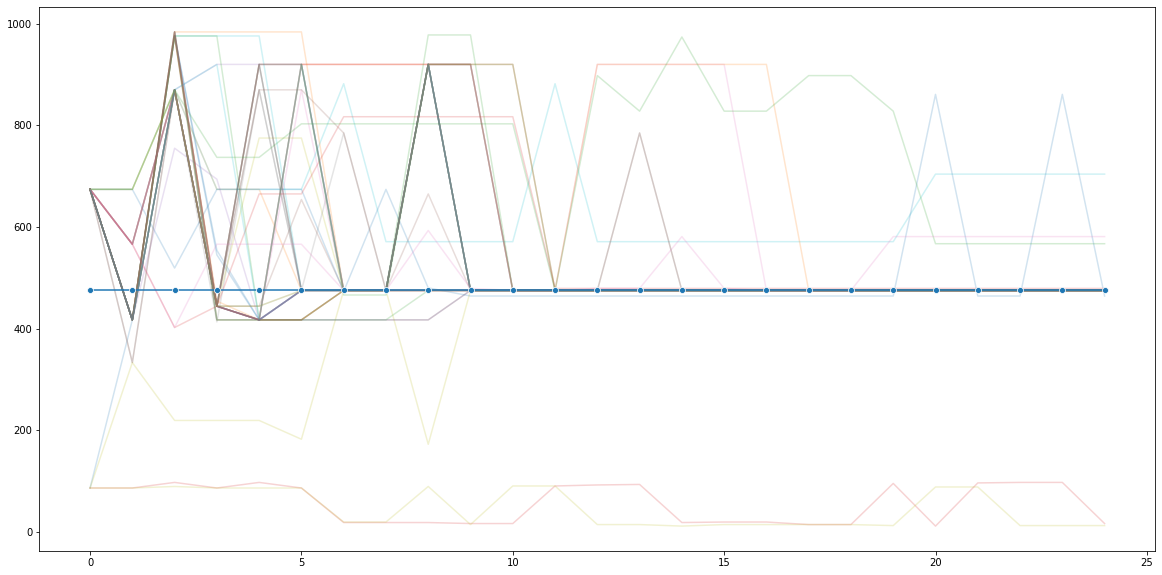

In [74]:
plt.rcParams["figure.figsize"] = (20,10)

i = 475
inds = np.where(labels.numpy() == i)[0]
print(inds)
print(freqs[i])

for ind in inds:
    y = [pred_list[k][ind] for k in range(len(pred_list))]
    x = [k for k in range(len(pred_list))]
    sns.lineplot(x=x, y=y, alpha=0.2)
    
y2 = [i for k in range(len(pred_list))]
sns.lineplot(x=x, y=y2, marker="o")

In [34]:
disagreements_test = []
for preds in zip(*pred_list):
    disagreements_test.append(len(np.unique(preds)))
print(len(disagreements_test))

20000


In [83]:
disagreement = np.array(disagreements_test)

diagreement_df = []
for i in range(1000):
    inds = np.where(labels_val.numpy() == i)
    num_disagreements = np.sum(disagreement[inds])/20.0
    diagreement_df.append([i, num_disagreements, freqs[i]])
    
diagreement_df = pd.DataFrame(diagreement_df, columns = ['label', 'num dsgrmnts', 'freq'])
diagreement_df

,label,num dsgrmnts,freq
0,0,6.75,50
1,1,4.45,250
2,2,4.05,516
3,3,3.50,352
4,4,4.35,143
...,...,...,...
995,995,5.10,167
996,996,6.20,19
997,997,4.05,25
998,998,6.70,21


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='freq', ylabel='num dsgrmnts'>

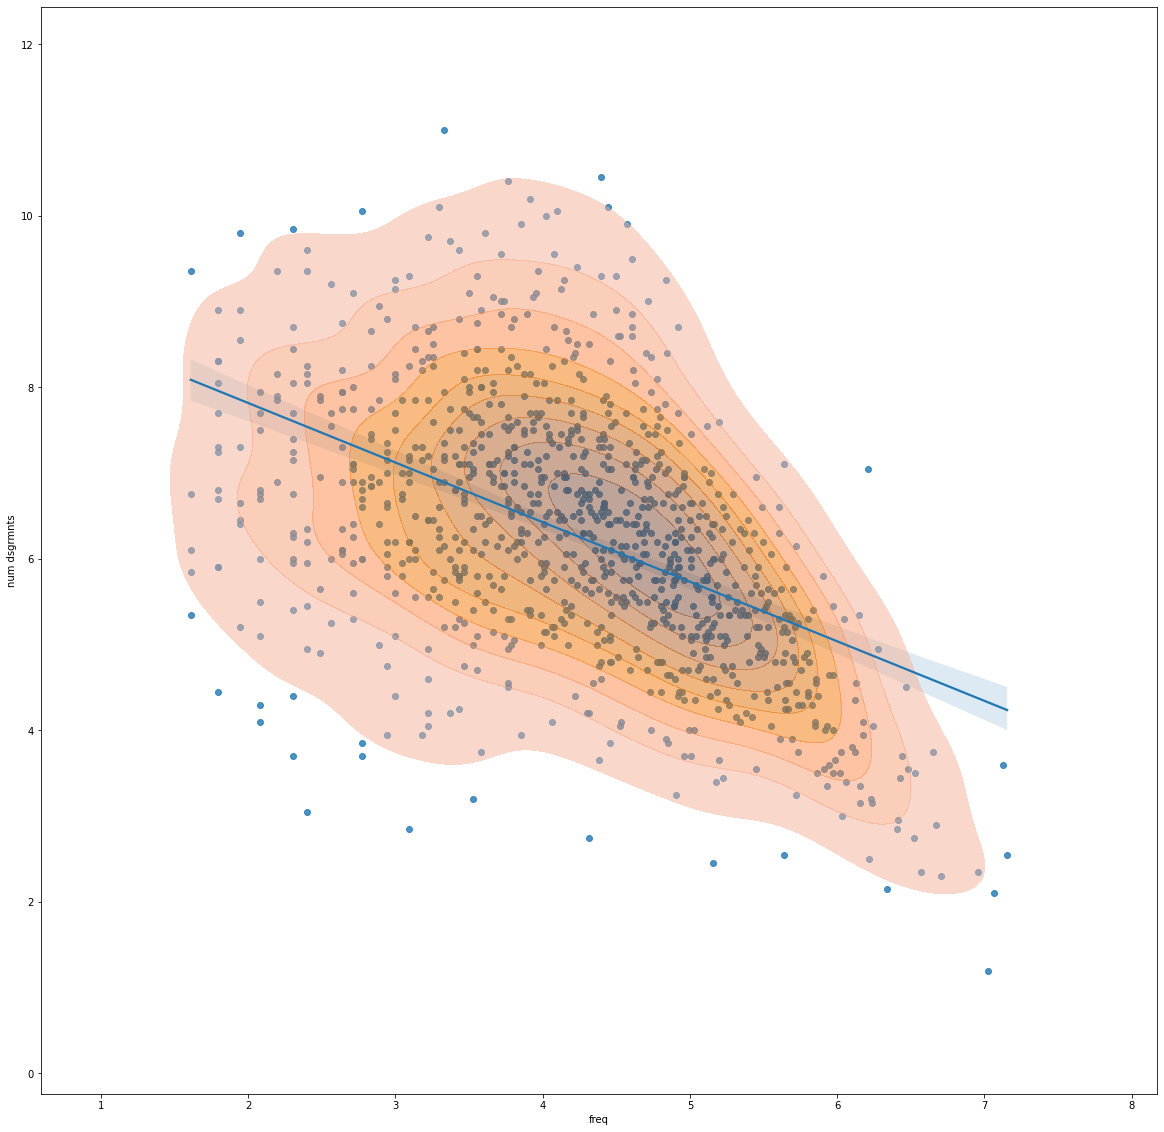

In [78]:
plt.rcParams["figure.figsize"] = (20,20)

graph = sns.regplot(data=diagreement_df, x = "freq", y = "num dsgrmnts")
sns.kdeplot(data=diagreement_df, x = "freq", y = "num dsgrmnts", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)



In [62]:
disagreement = np.array(disagreements_test)

diagreement_df = []
for i in range(labels_val.shape[0]):
    l = labels_val.numpy()[i]
    num_disagreements = disagreement[i]
    diagreement_df.append([l, num_disagreements, freqs[l]])
    
diagreement_df = pd.DataFrame(diagreement_df, columns = ['label', 'num dsgrmnts', 'freq'])
diagreement_df

,label,num dsgrmnts,freq
0,329,2,446
1,815,16,17
2,267,9,14
3,6,5,47
4,164,12,81
...,...,...,...
19995,492,7,154
19996,324,4,81
19997,223,5,11
19998,542,5,16


KeyboardInterrupt: 

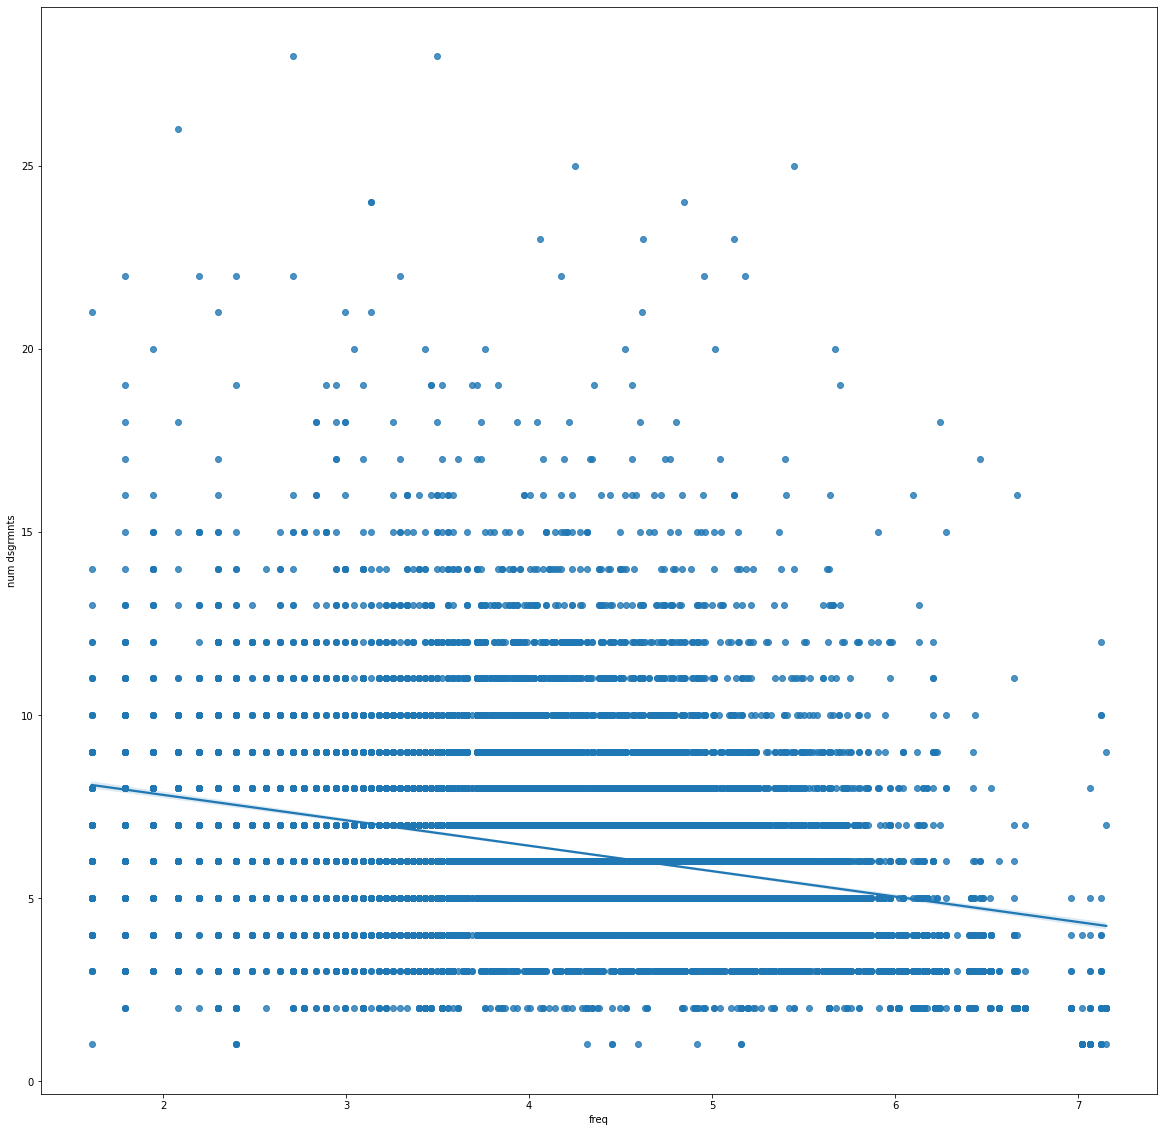

In [58]:
plt.rcParams["figure.figsize"] = (20,20)

graph = sns.regplot(data=diagreement_df, x = "freq", y = "num dsgrmnts")
sns.kdeplot(data=diagreement_df, x = "freq", y = "num dsgrmnts", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)



In [84]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit( np.expand_dims(diagreement_df["num dsgrmnts"].to_numpy(),-1),diagreement_df["freq"].to_numpy())

LinearRegression()

In [85]:
model.score( np.expand_dims(diagreement_df["num dsgrmnts"].to_numpy(),-1),diagreement_df["freq"].to_numpy())

0.30528039562795883

In [86]:
pickle.dump(model, open("disagreements_lm.sav", 'wb'))